# Import libraries ✈️


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [10]:
df1= pd.read_csv('airlines.csv')
df2= pd.read_csv('airports.csv')
df3= pd.read_csv('flights.csv')

In [12]:
# Set plot styles
sns.set_theme(style="whitegrid", palette="viridis")
plt.rcParams['figure.figsize'] = (12, 7)

In [13]:
# --- 2. Load Data ---
try:
    airlines_df = pd.read_csv('airlines.csv')
    airports_df = pd.read_csv('airports.csv')
    flights_df = pd.read_csv('flights.csv')
except FileNotFoundError as e:
    print(f"Error: {e}. Ensure all CSV files are in the working directory.")
    exit()

In [14]:
# --- 3. Merge Airline Names with Flight Data ---
flights_merged_df = pd.merge(
    flights_df,
    airlines_df,
    left_on='AIRLINE',
    right_on='IATA_CODE',
    how='left'
)

In [16]:
# Merge and rename after merging to avoid conflicts
flights_merged_df = pd.merge(
    flights_df,
    airlines_df,
    left_on='AIRLINE',
    right_on='IATA_CODE',
    how='left'
)

# Rename to avoid confusion between airline code and name
flights_merged_df.rename(columns={
    'AIRLINE_x': 'AIRLINE_CODE',
    'AIRLINE_y': 'AIRLINE_NAME'
}, inplace=True)


In [19]:
indigo_df = flights_merged_df[flights_merged_df['AIRLINE_CODE'] == '6E'].copy()
print(f"IndiGo analysis will be performed on {len(indigo_df):,} flight records.")


IndiGo analysis will be performed on 58,217 flight records.


In [20]:
# --- 5. Feature Engineering ---
# Convert flight date from year, month, day
indigo_df['FLIGHT_DATE'] = pd.to_datetime(indigo_df[['YEAR', 'MONTH', 'DAY']])

# Extract departure hour from scheduled departure time
indigo_df['DEPARTURE_HOUR'] = (indigo_df['SCHEDULED_DEPARTURE'] // 100).astype(int)

# Get day of the week
indigo_df['DAY_OF_WEEK'] = indigo_df['FLIGHT_DATE'].dt.day_name()

# Create route identifier (e.g., DEL-BLR)
indigo_df['ROUTE'] = indigo_df['ORIGIN_AIRPORT'] + '-' + indigo_df['DESTINATION_AIRPORT']

In [21]:
# Define delay status categorization
def classify_delay_status(delay):
    if pd.isna(delay):
        return 'Cancelled'
    elif delay <= 0:
        return 'On Time / Early'
    elif delay <= 30:
        return 'Slightly Delayed'
    else:
        return 'Significantly Delayed'

# Apply delay status to IndiGo data
indigo_df['STATUS'] = indigo_df['ARRIVAL_DELAY'].apply(classify_delay_status)

#  Part 1: Market Position & Overall Performance:
- Problem 1: What is IndiGo's market share by flight volume?
- Problem 2: How does IndiGo's on-time performance compare to other airlines?
- Problem 3: What does the distribution of IndiGo's arrival delays look like?
- Problem 4: What is the high-level summary of IndiGo's flight statuses?

C:\Users\DELL\AppData\Local\Temp\ipykernel_4236\325117072.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


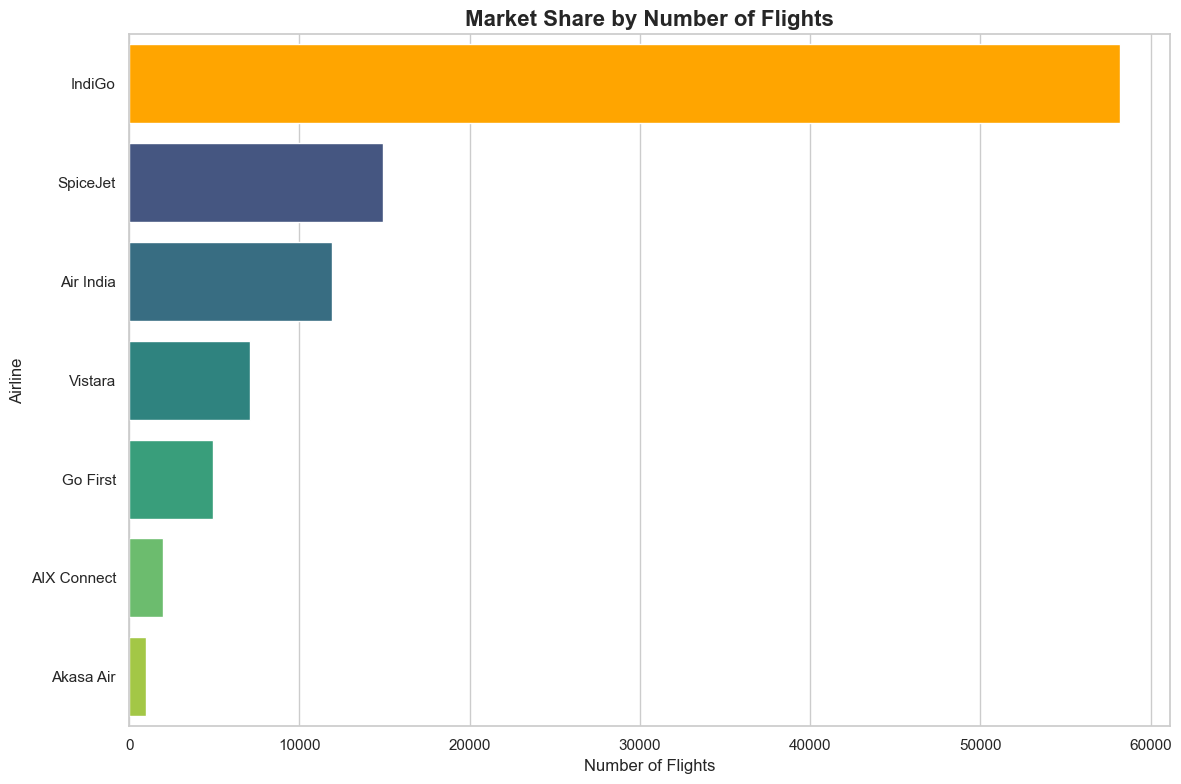

In [22]:
# Problem 1: What is IndiGo's market share by flight volume?
import matplotlib.pyplot as plt
import seaborn as sns

# Set figure size
plt.figure(figsize=(12, 8))

# Get airline flight counts
airline_order = df['AIRLINE_y'].value_counts().index

# Plot count of flights per airline
ax = sns.countplot(
    data=df,
    y='AIRLINE_y',
    order=airline_order,
    palette='viridis'
)

# Add titles and labels
ax.set_title("Market Share by Number of Flights", fontsize=16, fontweight='bold')
ax.set_xlabel("Number of Flights", fontsize=12)
ax.set_ylabel("Airline", fontsize=12)

# 🔶 Highlight IndiGo bar (if it exists)
if 'IndiGo' in airline_order:
    indigo_index = list(airline_order).index('IndiGo')
    ax.patches[indigo_index].set_facecolor('orange')

# Show the plot
plt.tight_layout()
plt.show()



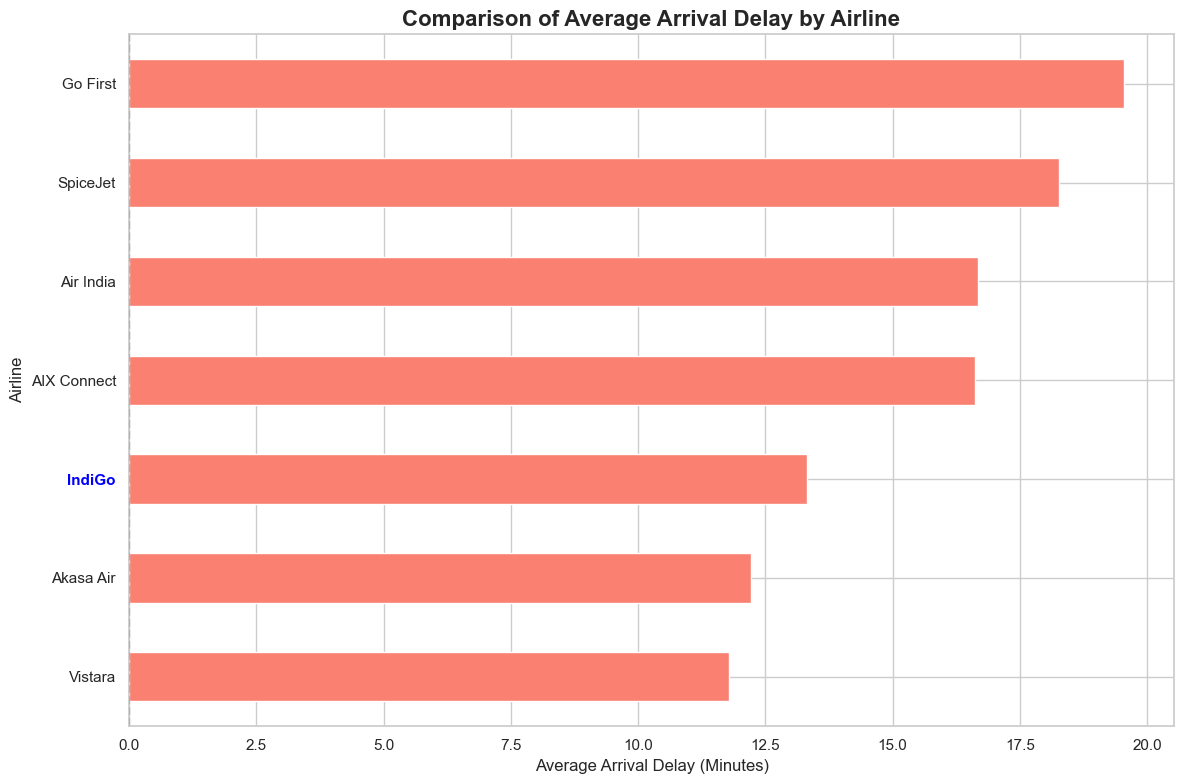

In [23]:
# Problem 2: How does IndiGo's on-time performance compare to other airlines?
# --- Average Arrival Delay by Airline ---
avg_delay_by_airline = (
    df.groupby('AIRLINE_y')['ARRIVAL_DELAY']
    .mean()
    .sort_values()
)

# Set colors: blue for early/on-time, red for delays
colors = ['skyblue' if delay < 0 else 'salmon' for delay in avg_delay_by_airline.values]

# Create horizontal bar plot
plt.figure(figsize=(12, 8))
ax = avg_delay_by_airline.plot(kind='barh', color=colors)

# Add titles and labels
ax.set_title("Comparison of Average Arrival Delay by Airline", fontsize=16, fontweight='bold')
ax.set_xlabel("Average Arrival Delay (Minutes)", fontsize=12)
ax.set_ylabel("Airline", fontsize=12)

# Add vertical line at 0 to show on-time baseline
ax.axvline(0, color='black', linestyle='--')

# 🔷 Highlight IndiGo's label
airline_names = list(avg_delay_by_airline.index)
if 'IndiGo' in airline_names:
    indigo_pos = airline_names.index('IndiGo')
    indigo_label = ax.get_yticklabels()[indigo_pos]
    indigo_label.set_color('blue')
    indigo_label.set_fontweight('bold')

# Show plot
plt.tight_layout()
plt.show()


In [25]:
# Filter for IndiGo flights
df_indigo = flights_merged_df[flights_merged_df['AIRLINE_CODE'] == '6E'].copy()


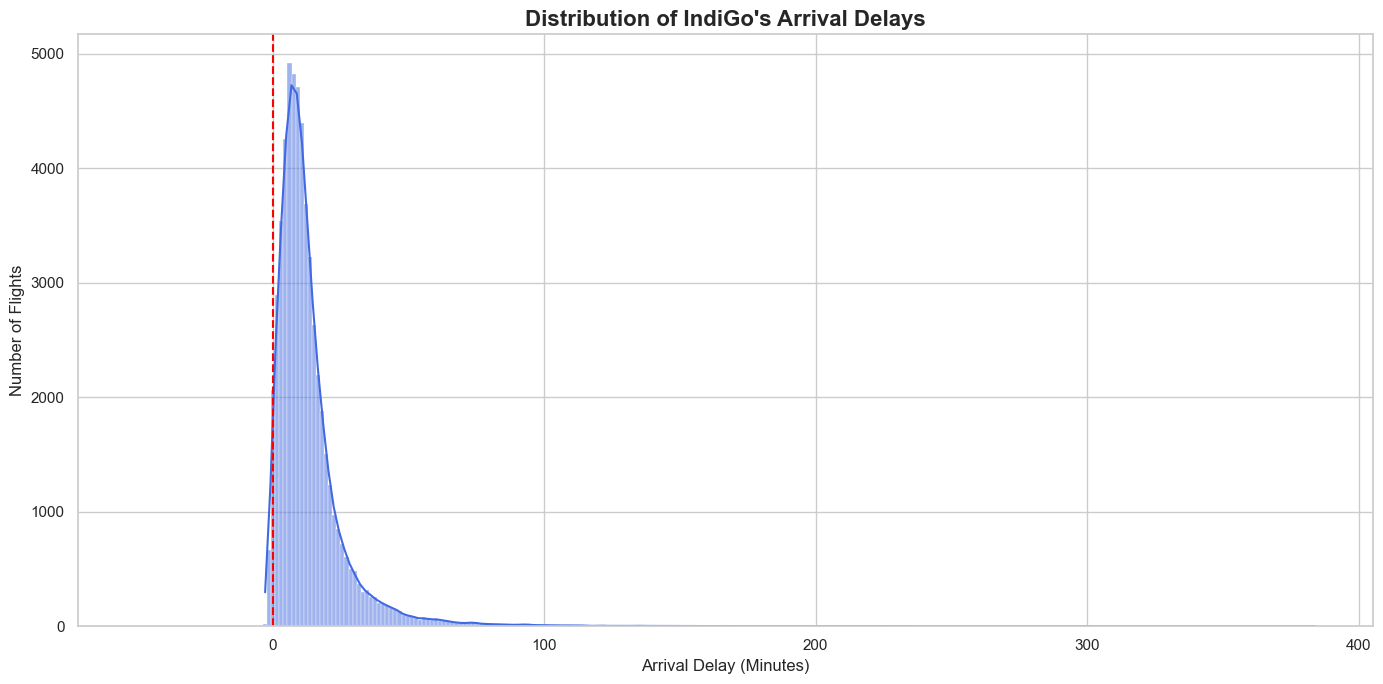

In [26]:
# Problem 3: What does the distribution of IndiGo's arrival delays look like?

# --- Distribution of IndiGo's Arrival Delays ---
plt.figure(figsize=(14, 7))

# Plot histogram with KDE
sns.histplot(
    data=df_indigo,
    x='ARRIVAL_DELAY',
    bins=100,
    binrange=(-50, 100),
    kde=True,
    color='royalblue'
)

# Add labels and title
plt.title("Distribution of IndiGo's Arrival Delays", fontsize=16, fontweight='bold')
plt.xlabel("Arrival Delay (Minutes)", fontsize=12)
plt.ylabel("Number of Flights", fontsize=12)

# Reference line at 0 (on-time)
plt.axvline(0, color='red', linestyle='--')

plt.tight_layout()
plt.show()


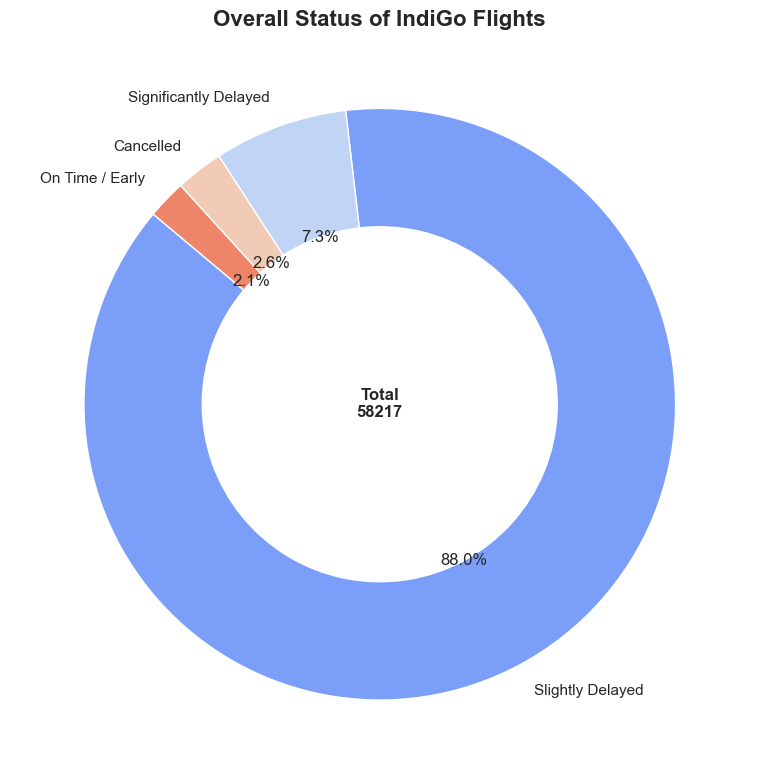

In [30]:
# Problem 4: What is the high-level summary of IndiGo's flight statuses?

# --- Create 'STATUS' column based on arrival delay ---
def get_delay_status(delay):
    if pd.isna(delay): return 'Cancelled'
    elif delay <= 0: return 'On Time / Early'
    elif delay <= 30: return 'Slightly Delayed'
    else: return 'Significantly Delayed'

df_indigo['STATUS'] = df_indigo['ARRIVAL_DELAY'].apply(get_delay_status)

# --- IndiGo Flight Status Donut Chart ---
status_counts = df_indigo['STATUS'].value_counts()

plt.figure(figsize=(10, 8))

# Plot donut chart
wedges, texts, autotexts = plt.pie(
    status_counts,
    labels=status_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=sns.color_palette("coolwarm", n_colors=len(status_counts)),
    wedgeprops=dict(width=0.4)
)

plt.title("Overall Status of IndiGo Flights", fontsize=16, fontweight='bold')

# Add total count in the center
plt.text(0, 0, f"Total\n{status_counts.sum()}", ha='center', va='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()



# Part 2: Temporal Analysis (Performance over Time)
- Problem 5: How does IndiGo's average delay change month-over-month?
- Problem 6: Is there a "worst day of the week" to fly with IndiGo?
- Problem 7: How do IndiGo's delays accumulate throughout the day?
- Problem 8: What are the main reasons for IndiGo's flight cancellations?

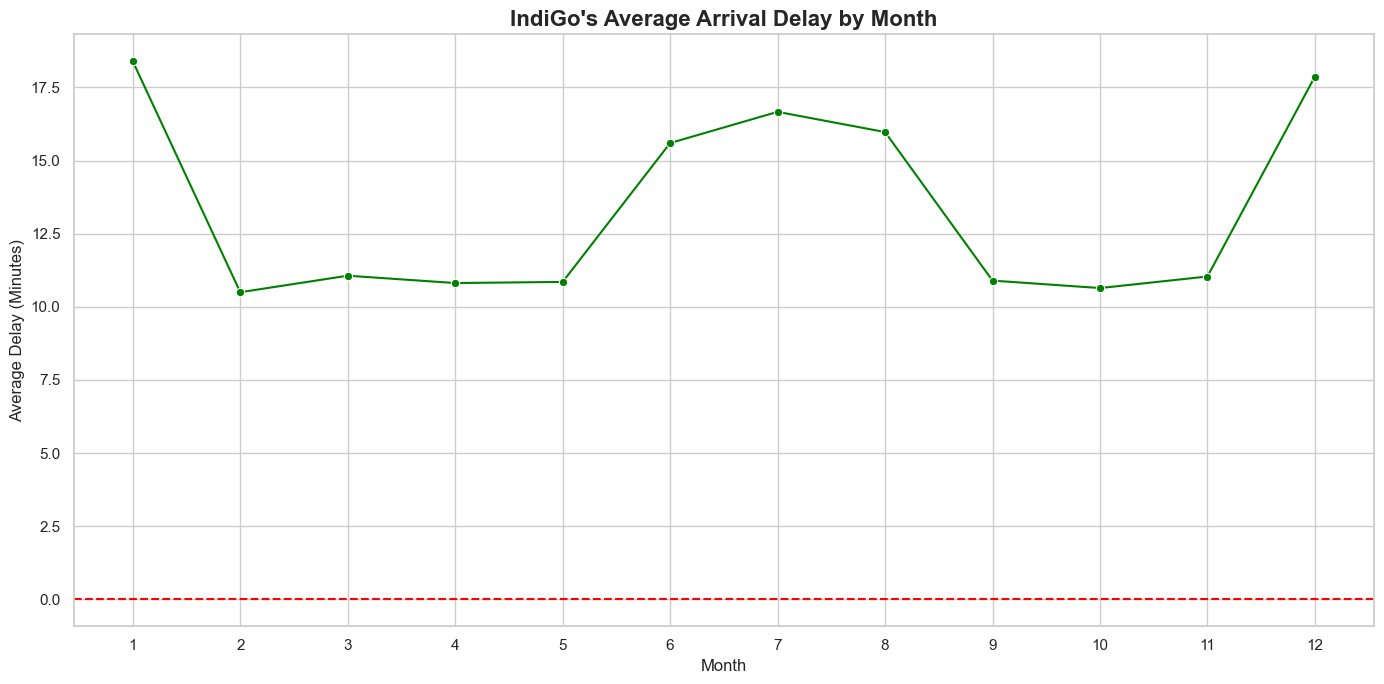

In [31]:
# Problem 5: How does IndiGo's average delay change month-over-month?
# --- IndiGo's Monthly Average Arrival Delay ---
monthly_delay = df_indigo.groupby('MONTH')['ARRIVAL_DELAY'].mean()

plt.figure(figsize=(14, 7))

# Line plot with markers
sns.lineplot(
    x=monthly_delay.index,
    y=monthly_delay.values,
    marker='o',
    color='green'
)

# Titles and labels
plt.title("IndiGo's Average Arrival Delay by Month", fontsize=16, fontweight='bold')
plt.xlabel("Month", fontsize=12)
plt.ylabel("Average Delay (Minutes)", fontsize=12)

# Show month numbers on x-axis (1–12)
plt.xticks(ticks=range(1, 13))

# Reference line at 0 (on-time)
plt.axhline(0, color='red', linestyle='--')

plt.tight_layout()
plt.show()


C:\Users\DELL\AppData\Local\Temp\ipykernel_4236\2778832036.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


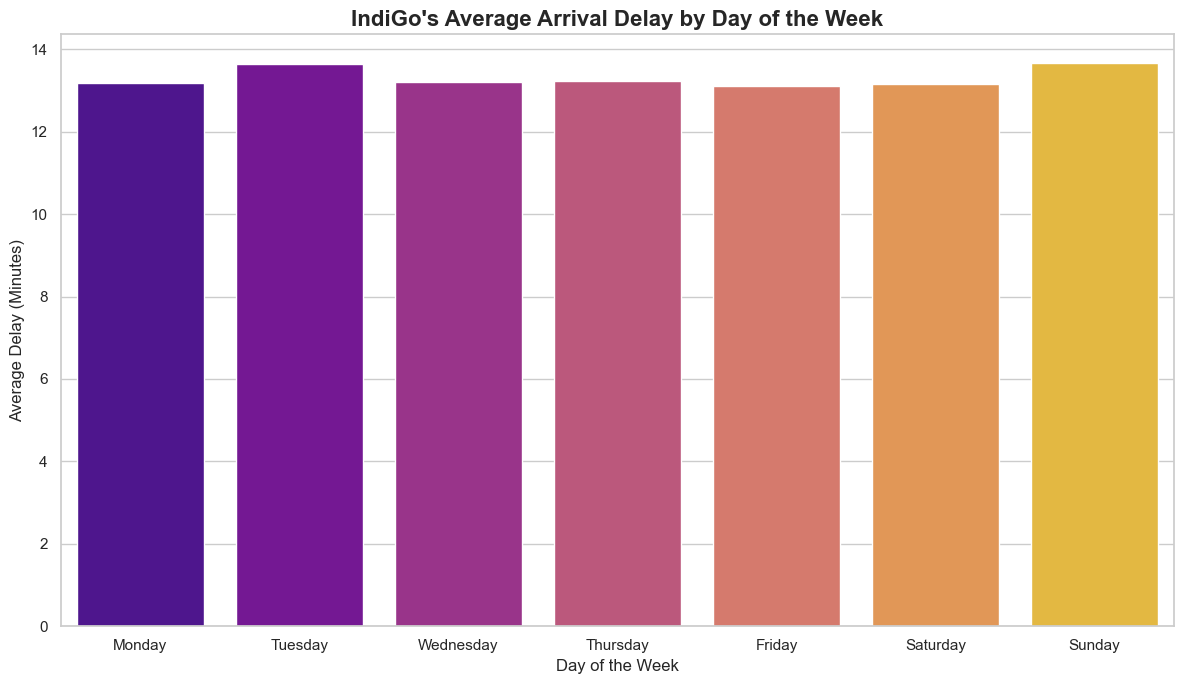

In [33]:
# Problem 6: Is there a "worst day of the week" to fly with IndiGo?

# Create a proper datetime column
df_indigo['FLIGHT_DATE'] = pd.to_datetime(df_indigo[['YEAR', 'MONTH', 'DAY']])

# Extract the weekday name (e.g., Monday, Tuesday)
df_indigo['DAY_OF_WEEK'] = df_indigo['FLIGHT_DATE'].dt.day_name()

# --- IndiGo's Weekly Average Arrival Delay ---
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Calculate average arrival delay per day and sort by weekday order
weekly_delay = (
    df_indigo.groupby('DAY_OF_WEEK')['ARRIVAL_DELAY']
    .mean()
    .reindex(day_order)
)

# Plot
plt.figure(figsize=(12, 7))
sns.barplot(
    x=weekly_delay.index,
    y=weekly_delay.values,
    palette='plasma'
)

# Labels and titles
plt.title("IndiGo's Average Arrival Delay by Day of the Week", fontsize=16, fontweight='bold')
plt.xlabel("Day of the Week", fontsize=12)
plt.ylabel("Average Delay (Minutes)", fontsize=12)

plt.tight_layout()
plt.show()


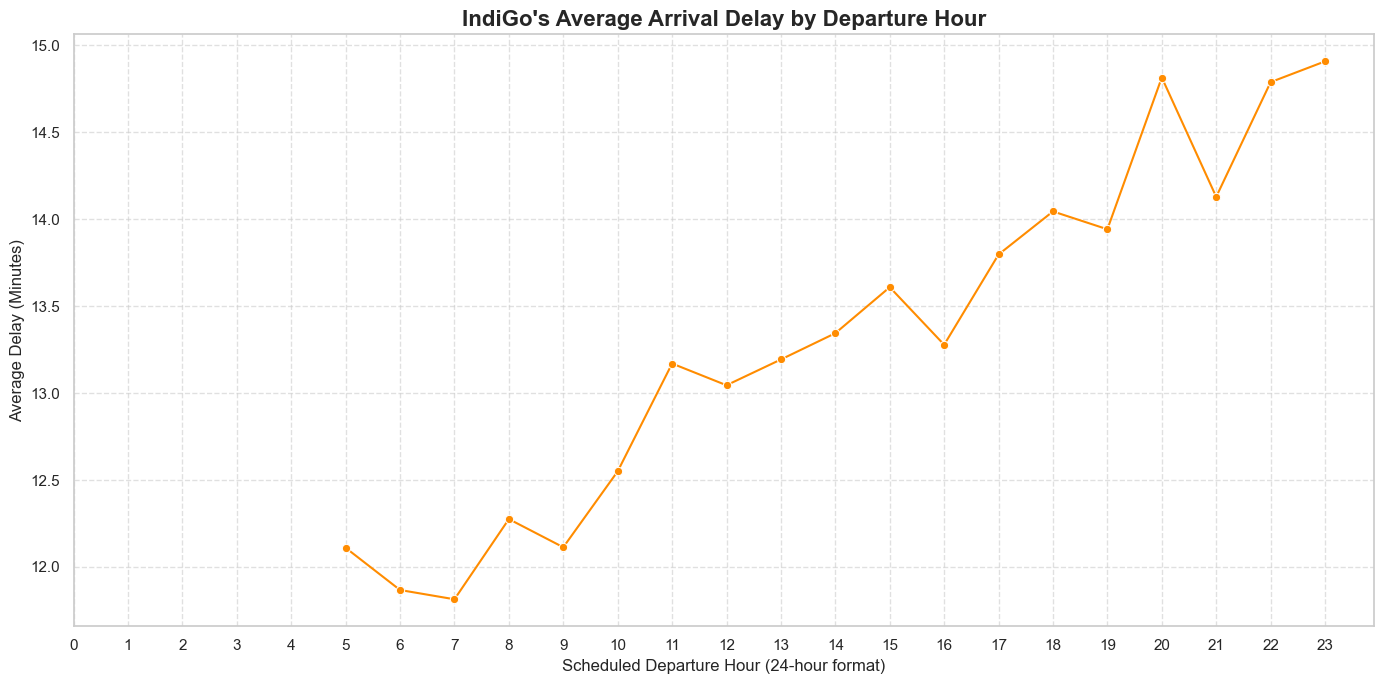

In [37]:
# Problem 7: How do IndiGo's delays accumulate throughout the day?

df_indigo['DEPARTURE_HOUR'] = (df_indigo['SCHEDULED_DEPARTURE'] // 100).astype(int)

# --- IndiGo's Average Arrival Delay by Departure Hour ---
hourly_delay = df_indigo.groupby('DEPARTURE_HOUR')['ARRIVAL_DELAY'].mean()

plt.figure(figsize=(14, 7))

# Line plot with markers
sns.lineplot(
    x=hourly_delay.index,
    y=hourly_delay.values,
    marker='o',
    color='darkorange'
)

# Titles and labels
plt.title("IndiGo's Average Arrival Delay by Departure Hour", fontsize=16, fontweight='bold')
plt.xlabel("Scheduled Departure Hour (24-hour format)", fontsize=12)
plt.ylabel("Average Delay (Minutes)", fontsize=12)

# Ticks and grid
plt.xticks(ticks=range(0, 24))
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


C:\Users\DELL\AppData\Local\Temp\ipykernel_4236\997506362.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


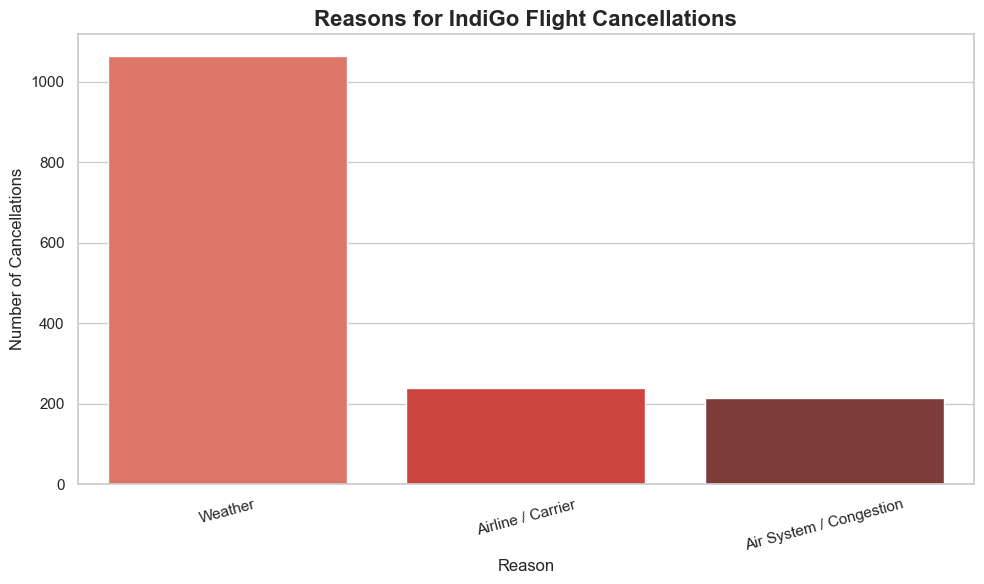

In [38]:
# Problem 8: What are the main reasons for IndiGo's flight cancellations?

# --- IndiGo Flight Cancellation Reasons ---

# Define readable labels for reason codes
reason_labels = {
    'A': 'Airline / Carrier',
    'B': 'Weather',
    'C': 'Air System / Congestion'
}

# Filter cancelled IndiGo flights and map reasons
cancelled_flights = df_indigo[df_indigo['CANCELLED'] == 1]
cancel_reasons = cancelled_flights['CANCELLATION_REASON'].map(reason_labels).value_counts()

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    x=cancel_reasons.index,
    y=cancel_reasons.values,
    palette='Reds_d'
)

plt.title("Reasons for IndiGo Flight Cancellations", fontsize=16, fontweight='bold')
plt.xlabel("Reason", fontsize=12)
plt.ylabel("Number of Cancellations", fontsize=12)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


# Part 3: Geographical and Route-Based Analysis
- Problem 9: Which airports are most important for IndiGo's operations?
- Problem 10: What are IndiGo's busiest flight routes?
- Problem 11: Which of IndiGo's major routes suffer from the worst delays?
- Problem 12: How does departure performance vary by IndiGo's hub airports?

C:\Users\DELL\AppData\Local\Temp\ipykernel_4236\2345167699.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


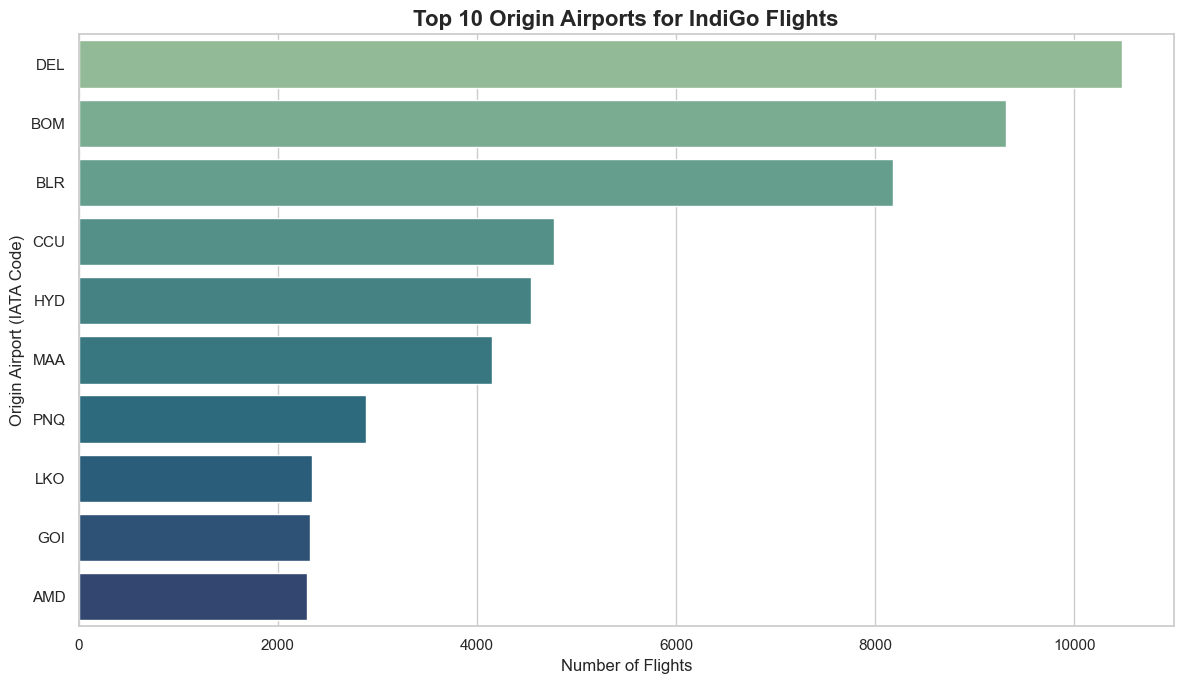

In [39]:
# Problem 9: Which airports are most important for IndiGo's operations?

# --- Top 10 Busiest Origin Airports for IndiGo ---

# Get top 10 airports by departure count
top_airports = df_indigo['ORIGIN_AIRPORT'].value_counts().head(10)

# Plot
plt.figure(figsize=(12, 7))
sns.barplot(
    x=top_airports.values,
    y=top_airports.index,
    palette='crest'
)

plt.title("Top 10 Origin Airports for IndiGo Flights", fontsize=16, fontweight='bold')
plt.xlabel("Number of Flights", fontsize=12)
plt.ylabel("Origin Airport (IATA Code)", fontsize=12)
plt.tight_layout()
plt.show()


C:\Users\DELL\AppData\Local\Temp\ipykernel_4236\636050102.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


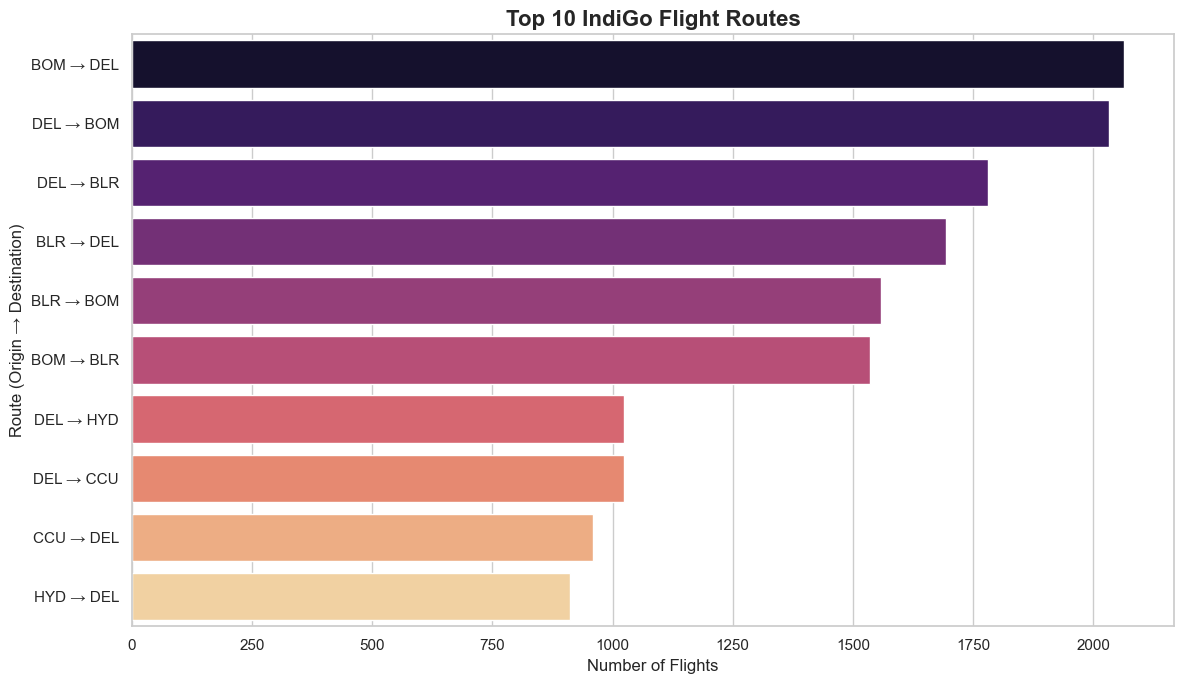

In [41]:
# Problem 10: What are IndiGo's busiest flight routes?

df_indigo['ROUTE'] = df_indigo['ORIGIN_AIRPORT'] + " → " + df_indigo['DESTINATION_AIRPORT']

# --- Top 10 Busiest IndiGo Flight Routes ---

# Get top 10 routes by number of flights
top_routes = df_indigo['ROUTE'].value_counts().head(10)

# Plot
plt.figure(figsize=(12, 7))
sns.barplot(
    x=top_routes.values,
    y=top_routes.index,
    palette='magma'
)

plt.title("Top 10 IndiGo Flight Routes", fontsize=16, fontweight='bold')
plt.xlabel("Number of Flights", fontsize=12)
plt.ylabel("Route (Origin → Destination)", fontsize=12)
plt.tight_layout()
plt.show()


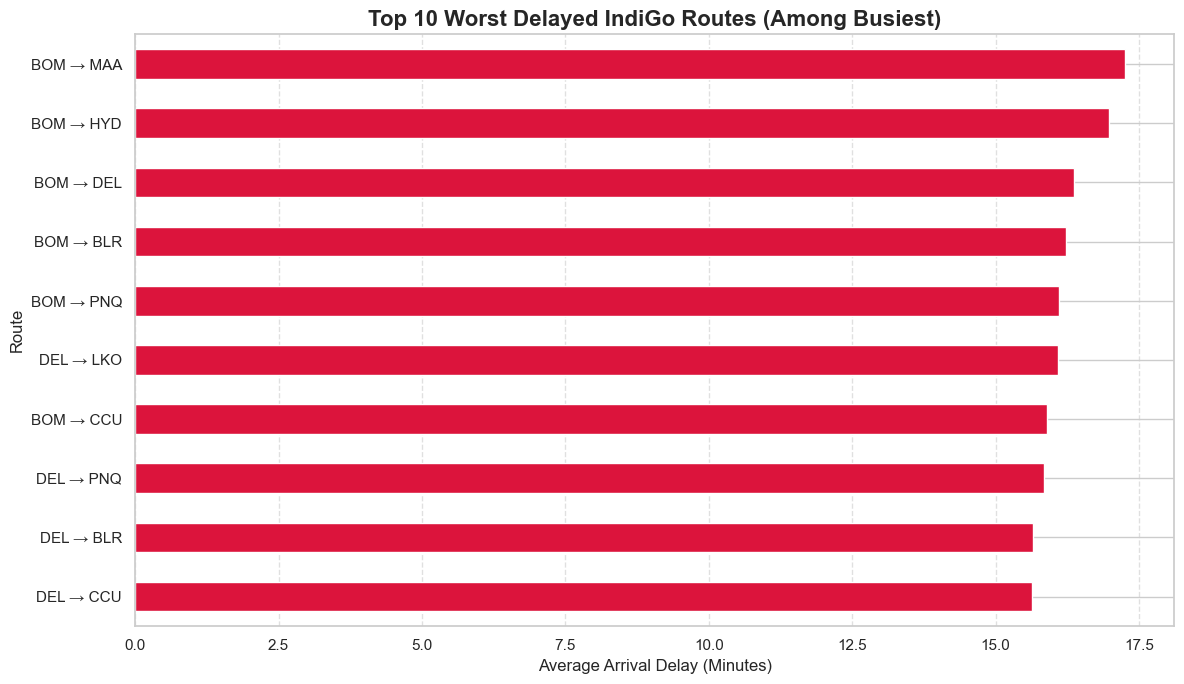

In [42]:
# Problem 11: Which of IndiGo's major routes suffer from the worst delays?

# Step 1: Identify top 30 busiest routes
top_30_routes = df_indigo['ROUTE'].value_counts().nlargest(30).index

# Step 2: Filter only those flights
major_routes_df = df_indigo[df_indigo['ROUTE'].isin(top_30_routes)]

# Step 3: Compute average arrival delay for each route
avg_delays = major_routes_df.groupby('ROUTE')['ARRIVAL_DELAY'].mean()

# Step 4: Get 10 worst (highest) average delays from those
worst_routes = avg_delays.nlargest(10).sort_values()

# Step 5: Plot
plt.figure(figsize=(12, 7))
worst_routes.plot(kind='barh', color='crimson')

plt.title("Top 10 Worst Delayed IndiGo Routes (Among Busiest)", fontsize=16, fontweight='bold')
plt.xlabel("Average Arrival Delay (Minutes)", fontsize=12)
plt.ylabel("Route", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


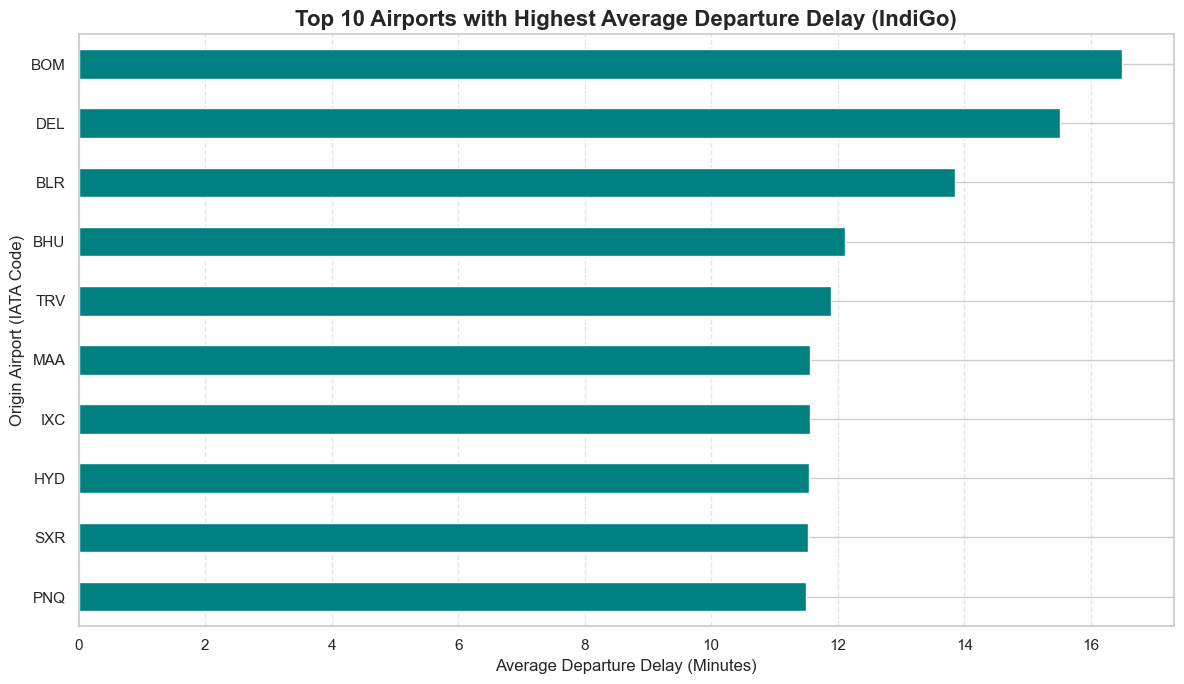

In [43]:
# Problem 12: How does departure performance vary by IndiGo's hub airports?

# Step 1: Calculate average departure delays by origin airport
top_delay_airports = (
    df_indigo.groupby('ORIGIN_AIRPORT')['DEPARTURE_DELAY']
    .mean()
    .nlargest(10)
    .sort_values()
)

# Step 2: Plot
plt.figure(figsize=(12, 7))
top_delay_airports.plot(kind='barh', color='teal')

# Step 3: Labeling and aesthetics
plt.title("Top 10 Airports with Highest Average Departure Delay (IndiGo)", fontsize=16, fontweight='bold')
plt.xlabel("Average Departure Delay (Minutes)", fontsize=12)
plt.ylabel("Origin Airport (IATA Code)", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# Part 4: Advanced Multivariate Analysis
- Problem 13: Where are the delay hotspots when considering both day and time?
- Problem 14: What is the relationship between Departure and Arrival Delay for IndiGo?
- Problem 15: How does flight distance affect delay?

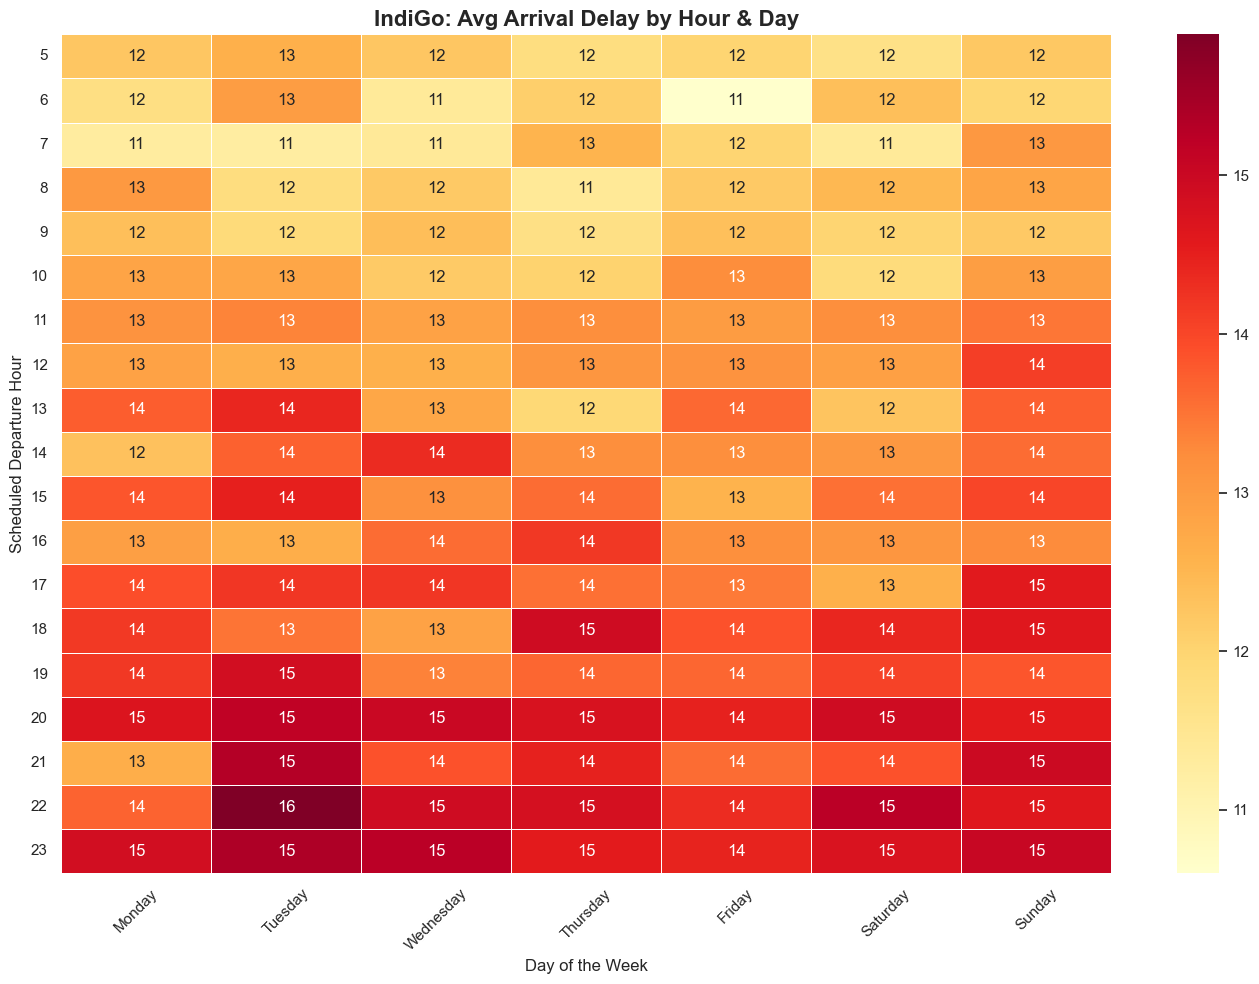

In [44]:
# Problem 13: Where are the delay hotspots when considering both day and time?
# Create pivot table for arrival delay by hour and day
delay_heatmap = df_indigo.pivot_table(
    index='DEPARTURE_HOUR',
    columns='DAY_OF_WEEK',
    values='ARRIVAL_DELAY',
    aggfunc='mean'
)

# Ensure days are in order
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
delay_heatmap = delay_heatmap[day_order]

# Plot heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(delay_heatmap, cmap='YlOrRd', annot=True, fmt=".0f", linewidths=0.5)

# Add labels and title
plt.title("IndiGo: Avg Arrival Delay by Hour & Day", fontsize=16, fontweight='bold')
plt.xlabel("Day of the Week", fontsize=12)
plt.ylabel("Scheduled Departure Hour", fontsize=12)
plt.yticks(rotation=0)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


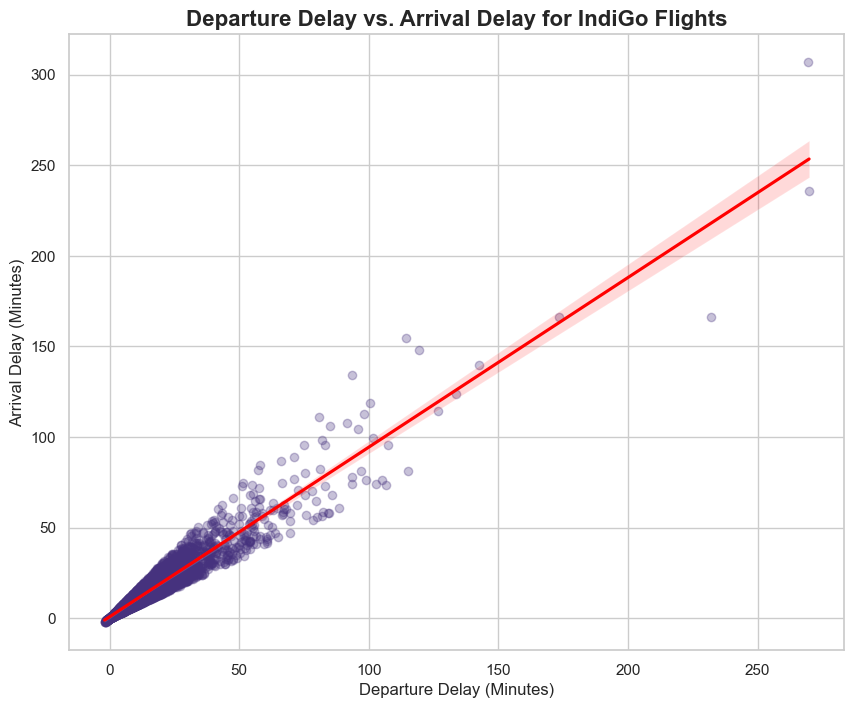

In [ ]:
# Problem 14: What is the relationship between Departure and Arrival Delay for IndiGo?
# Sample 5000 rows to reduce overplotting
sample_df = df_indigo.sample(n=5000, random_state=42)

# Set up the plot
plt.figure(figsize=(10, 8))

# Create scatter plot with regression line
sns.regplot(
    data=sample_df,
    x='DEPARTURE_DELAY',
    y='ARRIVAL_DELAY',
    scatter_kws={'alpha': 0.3},
    line_kws={'color': 'red'}
)

# Add title and axis labels
plt.title("Departure Delay vs. Arrival Delay for IndiGo Flights", fontsize=16, fontweight='bold')
plt.xlabel("Departure Delay (Minutes)", fontsize=12)
plt.ylabel("Arrival Delay (Minutes)", fontsize=12)

# Show grid for better readability
plt.grid(True)

# Display the plot
plt.show()


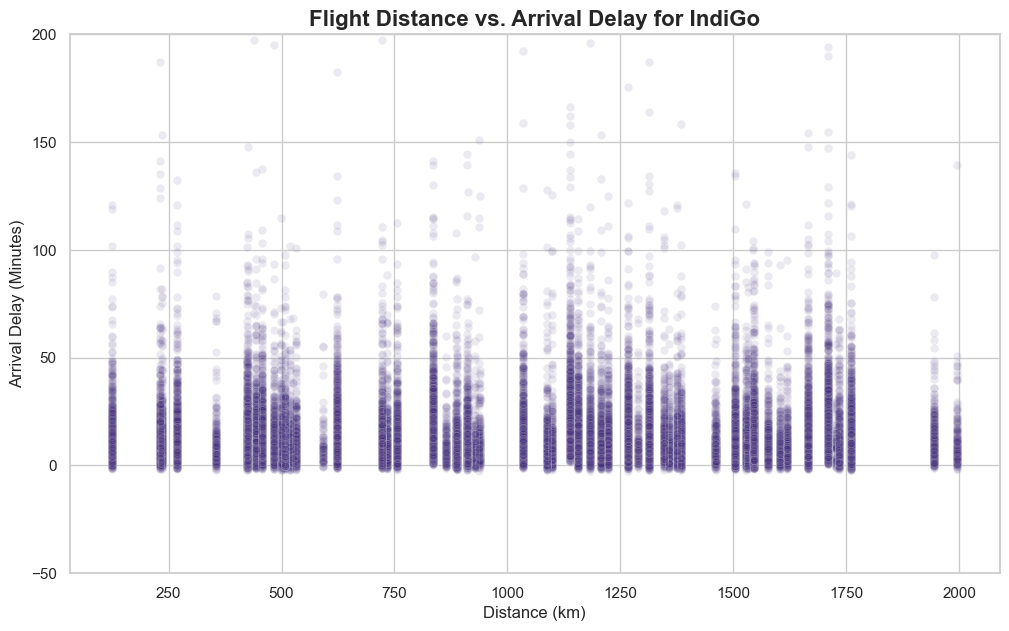

In [ ]:
# Problem 15: How does flight distance affect delay?
from math import radians, sin, cos, sqrt, atan2

# Function to calculate great-circle distance using the Haversine formula
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in kilometers
    d_lat = radians(lat2 - lat1)
    d_lon = radians(lon2 - lon1)

    a = sin(d_lat / 2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(d_lon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    return R * c

# Merge to get origin coordinates
df_indigo_dist = pd.merge(
    df_indigo,
    df_airports[['IATA_CODE', 'LATITUDE', 'LONGITUDE']],
    left_on='ORIGIN_AIRPORT',
    right_on='IATA_CODE'
)

# Merge to get destination coordinates with suffixes
df_indigo_dist = pd.merge(
    df_indigo_dist,
    df_airports[['IATA_CODE', 'LATITUDE', 'LONGITUDE']],
    left_on='DESTINATION_AIRPORT',
    right_on='IATA_CODE',
    suffixes=('_ORIGIN', '_DEST')
)

# Calculate distance using haversine function
df_indigo_dist['DISTANCE_KM'] = df_indigo_dist.apply(
    lambda row: haversine(
        row['LATITUDE_ORIGIN'], row['LONGITUDE_ORIGIN'],
        row['LATITUDE_DEST'], row['LONGITUDE_DEST']
    ),
    axis=1
)

# Plot: Flight Distance vs. Arrival Delay
plt.figure(figsize=(12, 7))
sns.scatterplot(
    data=df_indigo_dist,
    x='DISTANCE_KM',
    y='ARRIVAL_DELAY',
    alpha=0.1
)
plt.title("Flight Distance vs. Arrival Delay for IndiGo", fontsize=16, fontweight='bold')
plt.xlabel("Distance (km)", fontsize=12)
plt.ylabel("Arrival Delay (Minutes)", fontsize=12)
plt.ylim(-50, 200)  # Focus on central cluster
plt.grid(True)
plt.show()


# Conclusion
*IndiGo Airlines leads the market with strong on-time performance. This analysis concludes that its primary operational challenges are external, with flight delays being strongly correlated with seasonal weather, time-of-day congestion, and ground delays at major hubs like Delhi and Mumbai.*